# Customer Segmentation

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_c_train_fe = pd.read_pickle('data/df_c_train_fe.pkl')
df_customers = pd.read_csv('data/customers.csv')

In [3]:
# drop NA values and non-useful columns
cleaned_customers_df = df_customers.dropna(
    subset=["customer_id", "postal_code", "age", "fashion_news_frequency", "club_member_status"]).drop(columns=["FN", "postal_code", "club_member_status", "Active"])

# change "NONE" and "nan" values to "None"
cleaned_customers_df["fashion_news_frequency"] = df_customers["fashion_news_frequency"].replace({"NONE": "None", "None": "None"})

In [4]:
# merge df_c_train_fe with cleaned_customers_df to get age
df_c_train_fe = pd.merge(cleaned_customers_df, df_c_train_fe, on='customer_id', how='inner')

In [5]:
print("Head of df_c_train_fe:")
df_c_train_fe.head()

Head of df_c_train_fe:


,customer_id,fashion_news_frequency,age,total_spent,spending_power,preferred_products,preferred_colors,preferred_perceived_colors,combined_preferences,combined_preferences_embeddings,avg_time_diff_btw_purchase,hours_between_purchases
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,None,49.0,0.111814,Medium,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.12618253, 0.028975893, 0.045712247, -0.081...",11 days 12:00:00,276.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,None,25.0,0.782712,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.12618253, 0.028975893, 0.045712247, -0.081...",3 days 10:06:18.947368421,82.0
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,None,54.0,0.060983,Medium,Underwear,Black,Dark,"Underwear, Black, Dark","[-0.26786265, 0.3283508, -0.06105471, 0.118410...",0 days 00:00:00,8760.0
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,None,20.0,0.042339,Low,Swimwear,Dark Green,Medium Dusty,"Swimwear, Dark Green, Medium Dusty","[0.205381, -0.26421732, 0.22735098, -0.1606186...",0 days 00:00:00,8760.0
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,Regularly,56.0,0.772729,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.12618253, 0.028975893, 0.045712247, -0.081...",1 days 21:31:02.068965517,46.0


In [6]:
norm_unique_values_counts = df_c_train_fe['hours_between_purchases'].value_counts()
print(norm_unique_values_counts)

hours_between_purchases
8760.0    237556
24.0        5016
48.0        4359
72.0        3986
96.0        3445
           ...  
592.0         11
1632.0        10
1728.0         7
1776.0         4
1752.0         4
Name: count, Length: 384, dtype: int64


### Differentiating hours_between_purchases via quartiles
1. Exclude "no_repurchase_hours" first
2. Plot Histogram to observe distribution
3. Obtain quantiles
4. Categorise respectively into "Very Short", "Short", "Medium", "Long", "Very Long", "Never"

In [7]:
from sklearn.preprocessing import MinMaxScaler

# exclude "Never", in context of not repurchasing
df_for_scaling = df_c_train_fe[df_c_train_fe['hours_between_purchases'] != 8760.0].copy()

# Min-Max Scale to preserve the shape of the dataset's distribution but does not reduce the importance of outliers.
scaler = MinMaxScaler()
df_for_scaling['hours_between_purchases_scaled'] = scaler.fit_transform(df_for_scaling[['hours_between_purchases']])

# merge the scaled values back into the original DataFrame
df_c_train_fe = df_c_train_fe.merge(df_for_scaling[['hours_between_purchases_scaled']], left_index=True, right_index=True, how='left')

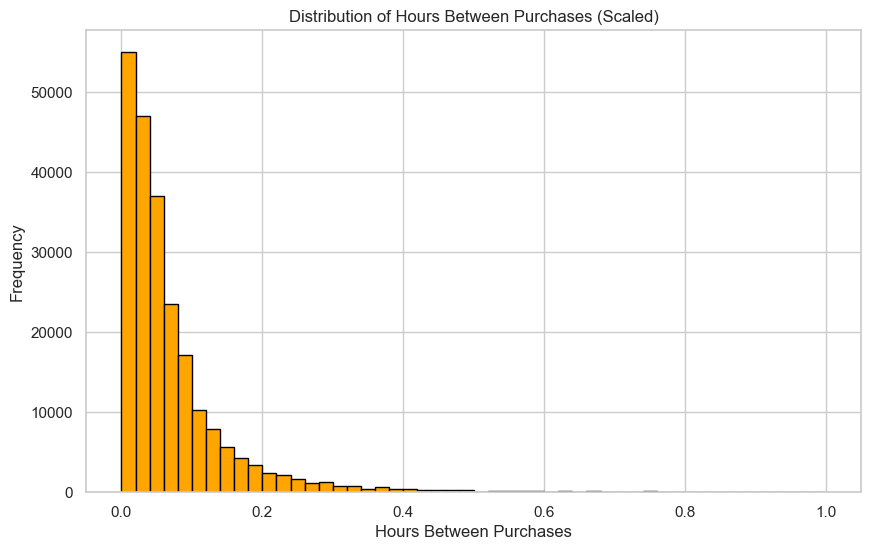

In [8]:
# plot histogram to see distribution
sns.set(style="whitegrid")

# Plotting the histogram
plt.figure(figsize=(10, 6)) 
plt.hist(df_for_scaling['hours_between_purchases_scaled'], bins=50, color='orange', edgecolor='black') 

plt.title('Distribution of Hours Between Purchases (Scaled)')
plt.xlabel('Hours Between Purchases')
plt.ylabel('Frequency')

plt.show()

In [9]:
# Calculate 5 Quantiles (20th, 40th, 60th, 80th percentiles)
quantiles = df_for_scaling['hours_between_purchases_scaled'].quantile([0.2, 0.4, 0.6, 0.8]).to_list()

# Print the calculated boundaries
print(f"Quartile Boundaries: {quantiles}")

Quartile Boundaries: [0.016901408450704224, 0.033802816901408454, 0.05746478873239437, 0.10197183098591549]


In [10]:
# converts numerical hours to categories
def categorise_hours(scaled_hours):
    if pd.isna(scaled_hours):  # This will catch the 8760 values which are NaN in 'hours_between_purchases_scaled'
        return "Never"
    elif scaled_hours <= quantiles[0]:
        return "Very Short"
    elif scaled_hours <= quantiles[1]:
        return "Short"
    elif scaled_hours <= quantiles[2]:
        return "Medium"
    elif scaled_hours <= quantiles[3]:
        return "Long"

    return "Very Long"

# apply categorization
df_c_train_fe['purchase_behaviour'] = df_c_train_fe['hours_between_purchases_scaled'].apply(categorise_hours)

# check the distribution of categories
print(df_c_train_fe['purchase_behaviour'].value_counts())

purchase_behaviour
Never         237556
Very Short     46362
Very Long      45150
Medium         45064
Long           45052
Short          44555
Name: count, dtype: int64


In [11]:
# drop 'hours_between_purchases_scaled' column
df_c_train_fe = df_c_train_fe.drop(columns=['hours_between_purchases_scaled'])

df_c_train_fe.head()

,customer_id,fashion_news_frequency,age,total_spent,spending_power,preferred_products,preferred_colors,preferred_perceived_colors,combined_preferences,combined_preferences_embeddings,avg_time_diff_btw_purchase,hours_between_purchases,purchase_behaviour
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,None,49.0,0.111814,Medium,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.12618253, 0.028975893, 0.045712247, -0.081...",11 days 12:00:00,276.0,Very Long
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,None,25.0,0.782712,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.12618253, 0.028975893, 0.045712247, -0.081...",3 days 10:06:18.947368421,82.0,Medium
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,None,54.0,0.060983,Medium,Underwear,Black,Dark,"Underwear, Black, Dark","[-0.26786265, 0.3283508, -0.06105471, 0.118410...",0 days 00:00:00,8760.0,Never
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,None,20.0,0.042339,Low,Swimwear,Dark Green,Medium Dusty,"Swimwear, Dark Green, Medium Dusty","[0.205381, -0.26421732, 0.22735098, -0.1606186...",0 days 00:00:00,8760.0,Never
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,Regularly,56.0,0.772729,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.12618253, 0.028975893, 0.045712247, -0.081...",1 days 21:31:02.068965517,46.0,Short


## Multi-Feature Clustering
1. Customer Characteristics: `'age', 'fashion_news_frequency'`

`K-Prototypes` - an extension of K-Means that can handle both numerical and categorical data, making it suitable for this mix of data types. It combines the K-Means objective function for numerical data with the K-Modes objective function for categorical data, allowing it to effectively find clusters within mixed data types.

Pro: Specifically designed for clustering mixed data types.

2. Transactional Behaviour:  `'spending_power', 'purchase_behaviour'`

`K-Modes` - clustering categorical data. It uses modes instead of means for clustering, which allows it to handle categories effectively by minimizing the dissimilarities between points in a cluster and maximizing the dissimilarities between different clusters.

Pro: Efficiently clusters categorical data without the need for conversion to numerical formats.

3. Product Preferences: `embeddings`

`HDBSCAN` - an advanced version of DBSCAN that works well with varying densities, which is common in embedding spaces. 

Pro: Can find clusters of varying shapes and sizes; no need to specify the number of clusters

### KPrototype for `'age', 'fashion_news_frequency'`
1. Find optimal number of clusters
2. Fit to training data
3. Plot a scatterplot to visualise the relationships between two variables and the clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/10, moves: 0, ncost: 905526.017099051
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/10, moves: 0, ncost: 905526.017099051
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/10, moves: 0, ncost: 905526.017099051
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/10, moves: 65, ncost: 179225.9922523753
Run: 1, iteration: 2/10, moves: 0, ncost: 179225.9922523753
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/10, moves: 231, ncost: 179352.64764786698
Run: 2, iteration: 2/10, moves: 29, ncost: 179225.9922523753
Run: 2, iteration: 3/10, moves: 0, ncost: 179225.9922523753
Init: initializing centroids
Init: init

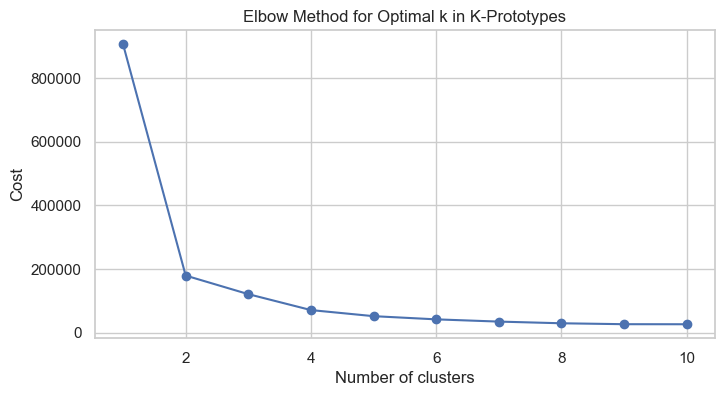

In [12]:
from kmodes.kprototypes import KPrototypes

# find optimal clusters for KProto
data = df_c_train_fe[['age', 'fashion_news_frequency']].copy()
data['fashion_news_frequency'] = data['fashion_news_frequency'].astype(str)

# random sample to improve run time
sampled_data = data.sample(frac=0.01, random_state=42)

costs = []
for k in range(1, 11):
    kproto = KPrototypes(n_clusters=k, init='Huang', n_init=3, max_iter=10, verbose=1)
    kproto.fit(sampled_data, categorical=[1])
    costs.append(kproto.cost_)

plt.figure(figsize=(8, 4))
plt.plot(range(1,11), costs, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k in K-Prototypes')
plt.show()

In [13]:
# Fit KPrototypes on the full dataset
# From above, optimal number of clusters is 2
kproto_full = KPrototypes(n_clusters=2, n_init=5, max_iter=10, verbose=2)
clusters_kp_full = kproto_full.fit_predict(
    df_c_train_fe[['age', 'fashion_news_frequency']],
    categorical=[1]
)

# Assign the cluster labels to the full dataset
df_c_train_fe['Customer_Characteristics_Cluster'] = clusters_kp_full

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/10, moves: 26125, ncost: 18675869.66951662
Run: 1, iteration: 2/10, moves: 4148, ncost: 18650159.229796976
Run: 1, iteration: 3/10, moves: 0, ncost: 18650159.229796976
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/10, moves: 86954, ncost: 18926067.669222523
Run: 2, iteration: 2/10, moves: 13928, ncost: 18652610.67047952
Run: 2, iteration: 3/10, moves: 1276, ncost: 18650159.229796976
Run: 2, iteration: 4/10, moves: 0, ncost: 18650159.229796976
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/10, moves: 22402, ncost: 18666213.88624141
Run: 3, iteration: 2/10, moves: 3280, ncost: 18650159.229796976
Run: 3, iteration: 3/10, moves: 0, ncost: 18650159.229796976
Init: initializing centroids
Init: initializing clus

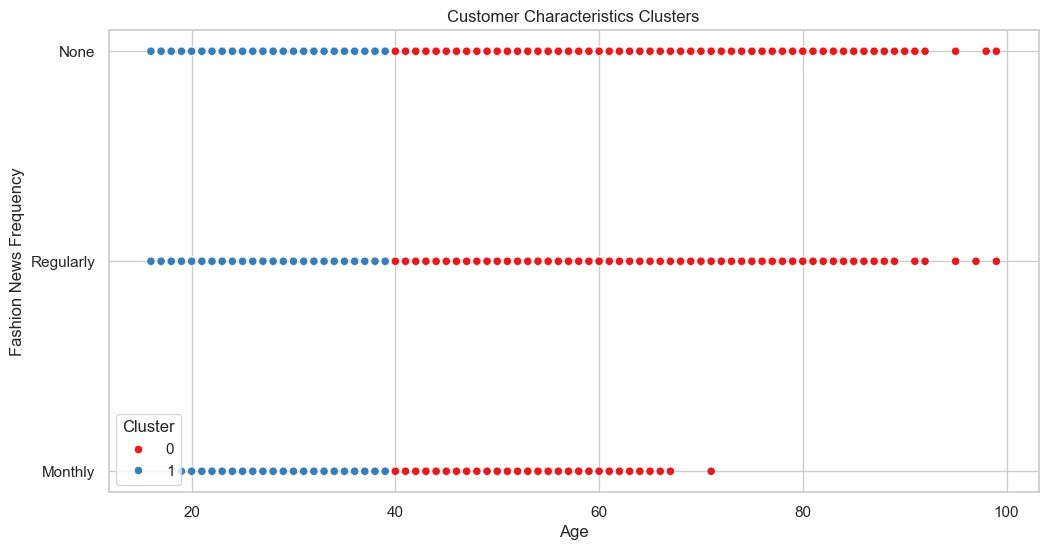

In [14]:
# convert the cluster labels to a categorical data type for color coding
df_c_train_fe['Customer_Characteristics_Cluster'] = df_c_train_fe['Customer_Characteristics_Cluster'].astype('category')

# create a scatter plot with 'age' on the x-axis and assign colors based on 'Customer_Characteristics_Cluster'
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_c_train_fe, x='age', y='fashion_news_frequency', hue='Customer_Characteristics_Cluster', palette='Set1')

plt.title('Customer Characteristics Clusters')
plt.xlabel('Age')
plt.ylabel('Fashion News Frequency')
plt.legend(title='Cluster')

plt.show()

### KModes for `'spending_power', 'purchase_behaviour'`
1. Find optimal number of clusters
2. Fit to training data
3. Plot a pivot table to visualise the relationships between two categorical variables and the clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/10, moves: 0, cost: 4624.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/10, moves: 0, cost: 4624.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/10, moves: 0, cost: 4624.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/10, moves: 0, cost: 4624.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/10, moves: 0, cost: 4624.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/10, moves: 19, cost: 3290.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/10, moves: 0, cost: 3467.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, i

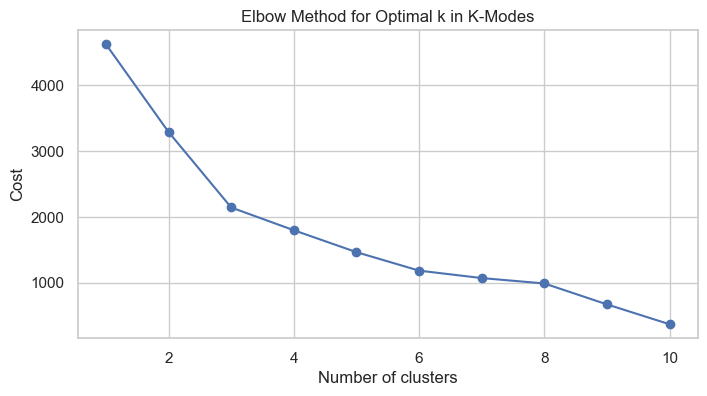

In [15]:
from kmodes.kmodes import KModes

# find optimal clusters for KModes
data_2 = df_c_train_fe[['spending_power', 'purchase_behaviour']].copy()

# random sample to improve run time
sampled_data_2 = data_2.sample(frac=0.01, random_state=42)

costs_2 = []
for k in range(1,11):
    km = KModes(n_clusters=k, init='Huang', n_init=5, max_iter=10, verbose=1)
    km.fit(sampled_data_2)
    costs_2.append(km.cost_)

plt.figure(figsize=(8, 4))
plt.plot(range(1,11), costs_2, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k in K-Modes')
plt.show()

In [16]:
# From above, the optimal number of clusters is 4
kmodes_full = KModes(n_clusters=4, init="Huang", n_init=10, max_iter=200, verbose=1)

kmodes_full.fit(df_c_train_fe[['spending_power', 'purchase_behaviour']])

# Directly obtain the cluster labels for the full dataset from the fitting process
clusters_km_full = kmodes_full.labels_

# Assign the cluster labels to the full dataset
df_c_train_fe['Transactional_Behaviour_Cluster'] = clusters_km_full

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/200, moves: 92117, cost: 259140.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/200, moves: 33904, cost: 264703.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/200, moves: 7355, cost: 198658.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/200, moves: 64897, cost: 292683.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/200, moves: 148946, cost: 180369.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/200, moves: 0, cost: 191020.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/200, moves: 37329, cost: 267392.0
Init: initializing centroids
Init: initializing clusters
Starting 

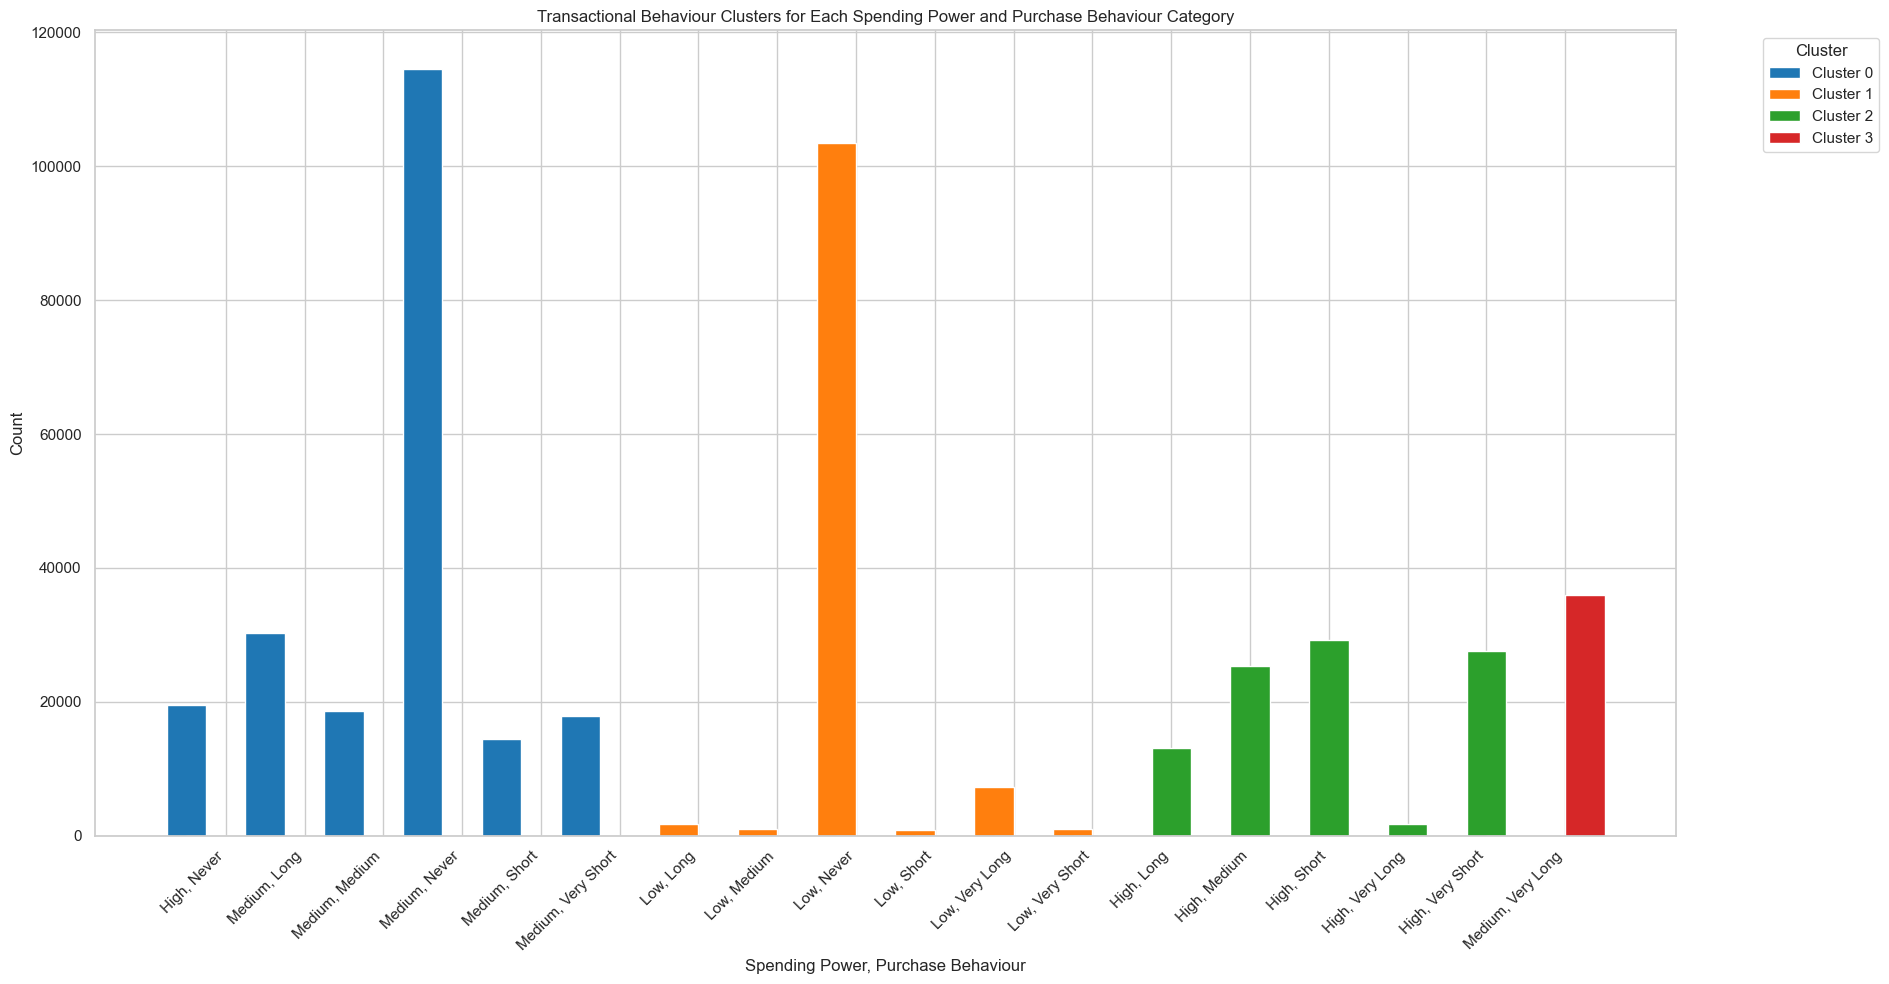

In [54]:
plot_data = df_c_train_fe.groupby(['Transactional_Behaviour_Cluster', 'spending_power', 'purchase_behaviour']).size().reset_index(name='count')

plot_data['category'] = plot_data[['spending_power', 'purchase_behaviour']].apply(tuple, axis=1)

categories = plot_data['category'].unique()

plt.figure(figsize=(19, 10))

n_clusters = plot_data['Transactional_Behaviour_Cluster'].nunique()
n_categories = len(categories)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

bar_width = 1.5

xticks_positions = []

# Plot each cluster's bars
for cluster_num in range(n_clusters):
    # Filter the data for the current cluster
    cluster_data = plot_data[plot_data['Transactional_Behaviour_Cluster'] == cluster_num]
    
    bar_positions = []
    
    # Plot each category's bar for the current cluster
    for i, category in enumerate(categories):
        x_position = i * (n_clusters * bar_width) + cluster_num * bar_width
        
        if cluster_num == 0:
            xticks_positions.append(x_position + (n_clusters * bar_width) / 2)
        
        # Get the count for the current category in the current cluster
        count = cluster_data[cluster_data['category'] == category]['count'].iloc[0] if not cluster_data[cluster_data['category'] == category].empty else 0

        plt.bar(x_position, count, width=3.0, color=colors[cluster_num], label=f'Cluster {cluster_num}' if i == 0 else "")
        
plt.xticks(xticks_positions, [f'{sp}, {pb}' for sp, pb in categories], rotation=45, ha='right')

plt.title('Transactional Behaviour Clusters for Each Spending Power and Purchase Behaviour Category')
plt.xlabel('Spending Power, Purchase Behaviour')
plt.ylabel('Count')

plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [27]:
df_c_train_fe["Customer_Characteristics_Cluster"] = df_c_train_fe['Customer_Characteristics_Cluster'].astype('uint16')

### HDBSCAN for `'combined_preferences_embeddings'`
1. Normalise through normalize()
2. PCA to reduce dimensions to improve runtime
3. Tune Hyperparameters
4. Output clusters and save to df_c_train_fe

In [ ]:
# %pip install hdbscan

Number of components to retain 99.9% of variance: 20


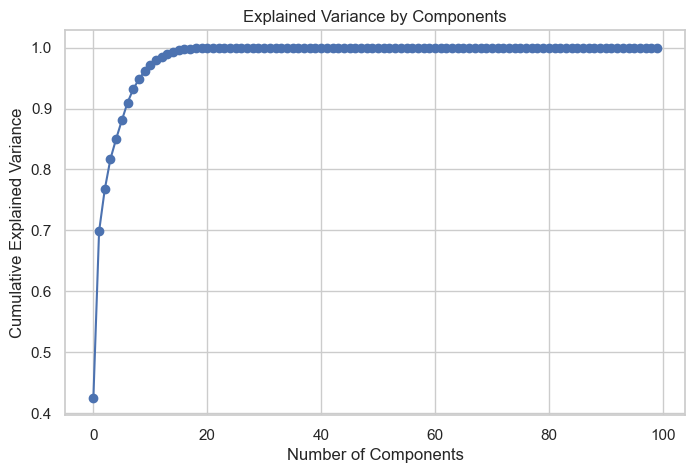

In [66]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

embeddings = np.stack(df_c_train_fe['combined_preferences_embeddings'].values)

# normalize the embeddings to unit norm
embeddings_normalized = normalize(embeddings)

pca = PCA()
pca.fit(embeddings_normalized)

# cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.title('Explained Variance by Components')

# choose n_components where cumulative variance is above 0.999
n_components = (cumulative_explained_variance < 0.999).sum() + 1

print(f"Number of components to retain 99.9% of variance: {n_components}")

In [ ]:
import hdbscan

# from above, 20 is ideal
pca = PCA(n_components=20)
embeddings_reduced = pca.fit_transform(embeddings_normalized)

# tune hyperparameters
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(0.01 / 100 * len(embeddings_reduced)),  # 0.01% of dataset size
    min_samples=10,
    metric='euclidean',
    gen_min_span_tree=False
)

cluster_hdbscan_full = clusterer.fit_predict(embeddings_reduced)

df_c_train_fe['Product_Preference_Clusters'] = cluster_hdbscan_full

In [61]:
df_c_midway = pd.read_pickle('data/df_c_midway.pkl')
df_c_train_fe['Product_Preference_Clusters'] = df_c_midway['Product_Preference_Clusters']
df_c_train_fe = df_c_train_fe.merge(df_c_midway[['customer_id', 'Product_Preference_Clusters']], on='customer_id', how='left')

In [63]:
print(df_c_train_fe['Customer_Characteristics_Cluster'].unique())
print(df_c_train_fe['Transactional_Behaviour_Cluster'].unique())
print(df_c_train_fe['Product_Preference_Clusters'].unique().size)

[0 1]
[3 2 0 1]
516


In [64]:
print(df_c_train_fe['Product_Preference_Clusters'].value_counts())

Product_Preference_Clusters
130    79141
125    56821
131    34471
23     27053
254    21296
       ...  
273       46
22        46
17        46
333       45
330       44
Name: count, Length: 516, dtype: int64


In [65]:
df_c_train_fe.to_pickle(os.path.join(os.getcwd(),'data', 'df_c_train_cs.pkl'))

# Portion below is Teow's EDA

### Number of clusters 

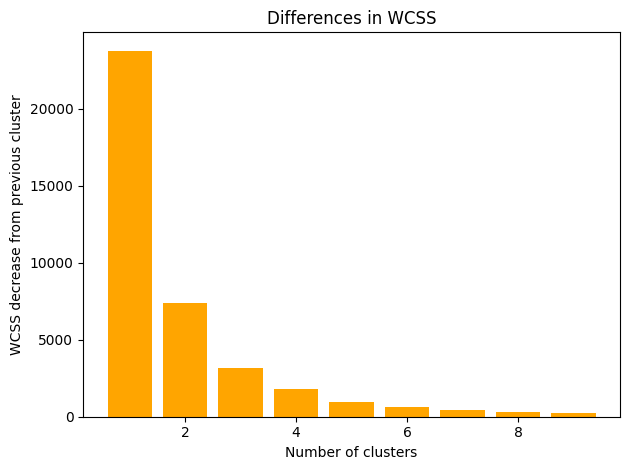

In [47]:
# Compute the differences in consecutive WCSS values to choose number of clusters
wcss_diff = [wcss[i - 1] - wcss[i] for i in range(1, len(wcss))]
plt.bar(range(1, 10), wcss_diff, color='orange')
plt.title('Differences in WCSS')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS decrease from previous cluster')


plt.tight_layout()
plt.show()

#### Upon visual inspection of the Elbow Method graph, it is evident that the elbow point is approximately around ***3 clusters***. Additionally, analyzing the difference in consecutive WCSS values provides further insight into the optimal number of clusters. Notably, the most substantial drop in WCSS occurs when transitioning from 2 to 3 clusters, suggesting that the addition of a third cluster significantly improves the clustering quality. 

#### However, beyond three clusters, the decrease in WCSS becomes less pronounced, indicating diminishing returns in terms of clustering improvement. Moreover, increasing the number of clusters excessively may lead to overfitting, where the model captures noise in the data rather than meaningful patterns, potentially reducing the generalization ability of the clustering model. Therefore, based on both visual inspection and the analysis of WCSS differences, selecting three clusters appears to be a reasonable choice for this dataset.

### Categorising Spending Power

In [48]:
quantiles_train = df_c_train_reduced['total_spent'].quantile([0, 0.25, 0.75, 1.0])
quantiles_val = df_c_val_reduced['total_spent'].quantile([0, 0.25, 0.75, 1.0])
quantiles_test = df_c_test_reduced['total_spent'].quantile([0, 0.25, 0.75, 1.0])

def categorize_spending_power(amount, quantiles):
    if amount <= quantiles[0.25]:
        return 'low'
    elif amount <= quantiles[0.75]:
        return 'medium'
    else:
        return 'high'

df_c_train_reduced['spending_power'] = df_c_train_reduced['total_spent'].apply(lambda x: categorize_spending_power(x, quantiles_train))
df_c_val_reduced['spending_power'] = df_c_val_reduced['total_spent'].apply(lambda x: categorize_spending_power(x, quantiles_val))
df_c_test_reduced['spending_power'] = df_c_test_reduced['total_spent'].apply(lambda x: categorize_spending_power(x, quantiles_test))

In [53]:
print(df_c_test_reduced['spending_power'].value_counts())
print(df_c_val_reduced['spending_power'].value_counts())
print(df_c_train_reduced['spending_power'].value_counts())
print(df_c_train_reduced)

spending_power
medium    148271
low        74241
high       74171
Name: count, dtype: int64
spending_power
medium    108324
low        54783
high       54369
Name: count, dtype: int64
spending_power
medium    234880
low       117452
high      117441
Name: count, dtype: int64
                                              customer_id  total_spent  \
0       00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...     0.111814   
1       0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...     0.782712   
2       00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...     0.060983   
3       0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...     0.042339   
4       00009d946eec3ea54add5ba56d5210ea898def4b46c685...     0.772729   
...                                                   ...          ...   
469768  ffff1c80bd2dede87deda612527c3df06d2fb270b85602...     0.064356   
469769  ffff4c4e8b57b633c1ddf8fbd53db16b962cf831baf9ed...     0.101610   
469770  ffff61677073258d461e043cc9ed4ed97be5617a920640... 

### Insights into product types purchased by different spending power groups

In [73]:
# Tagging products purchased to customers
df_train_merged = pd.merge(df_t_train, df_i[['article_id', 'product_type_name']], on='article_id', how='left')
df_val_merged = pd.merge(df_t_val, df_i[['article_id', 'product_type_name']], on='article_id', how='left')
df_test_merged = pd.merge(df_t_test, df_i[['article_id', 'product_type_name']], on='article_id', how='left')

df_train_merged_with_spending_power = pd.merge(df_train_merged, df_c_train_reduced[['customer_id', 'spending_power']], on='customer_id', how='left')
df_val_merged_with_spending_power = pd.merge(df_val_merged, df_c_val_reduced[['customer_id', 'spending_power']], on='customer_id', how='left')
df_test_merged_with_spending_power = pd.merge(df_test_merged, df_c_test_reduced[['customer_id', 'spending_power']], on='customer_id', how='left')

print("Train Data:")
print(df_train_merged_with_spending_power.head())

print("\nValidation Data:")
print(df_val_merged_with_spending_power.head())

print("\nTest Data:")
print(df_test_merged_with_spending_power.head())


Train Data:
       t_dat                                        customer_id  article_id  \
0 2019-04-01  000747860042b94e85707605c2a627c6ba30c4117d025d...   732725002   
1 2019-04-01  001021122bdb55ec4235f35eb50164c268ec7c4bcfff90...   697060014   
2 2019-04-01  001021122bdb55ec4235f35eb50164c268ec7c4bcfff90...   758200004   
3 2019-04-01  0021ce2be745fe55f9b2bc784dbfd0e374c315ccd15aab...   769965001   
4 2019-04-01  0021ce2be745fe55f9b2bc784dbfd0e374c315ccd15aab...   709269004   

      price  sales_channel_id product_type_name spending_power  
0  0.050831                 1             Dress           high  
1  0.025407                 2            Blouse           high  
2  0.067780                 2            Blouse           high  
3  0.042356                 2             Dress           high  
4  0.042356                 2             Dress           high  

Validation Data:
       t_dat                                        customer_id  article_id  \
0 2019-06-15  00015c1a121e

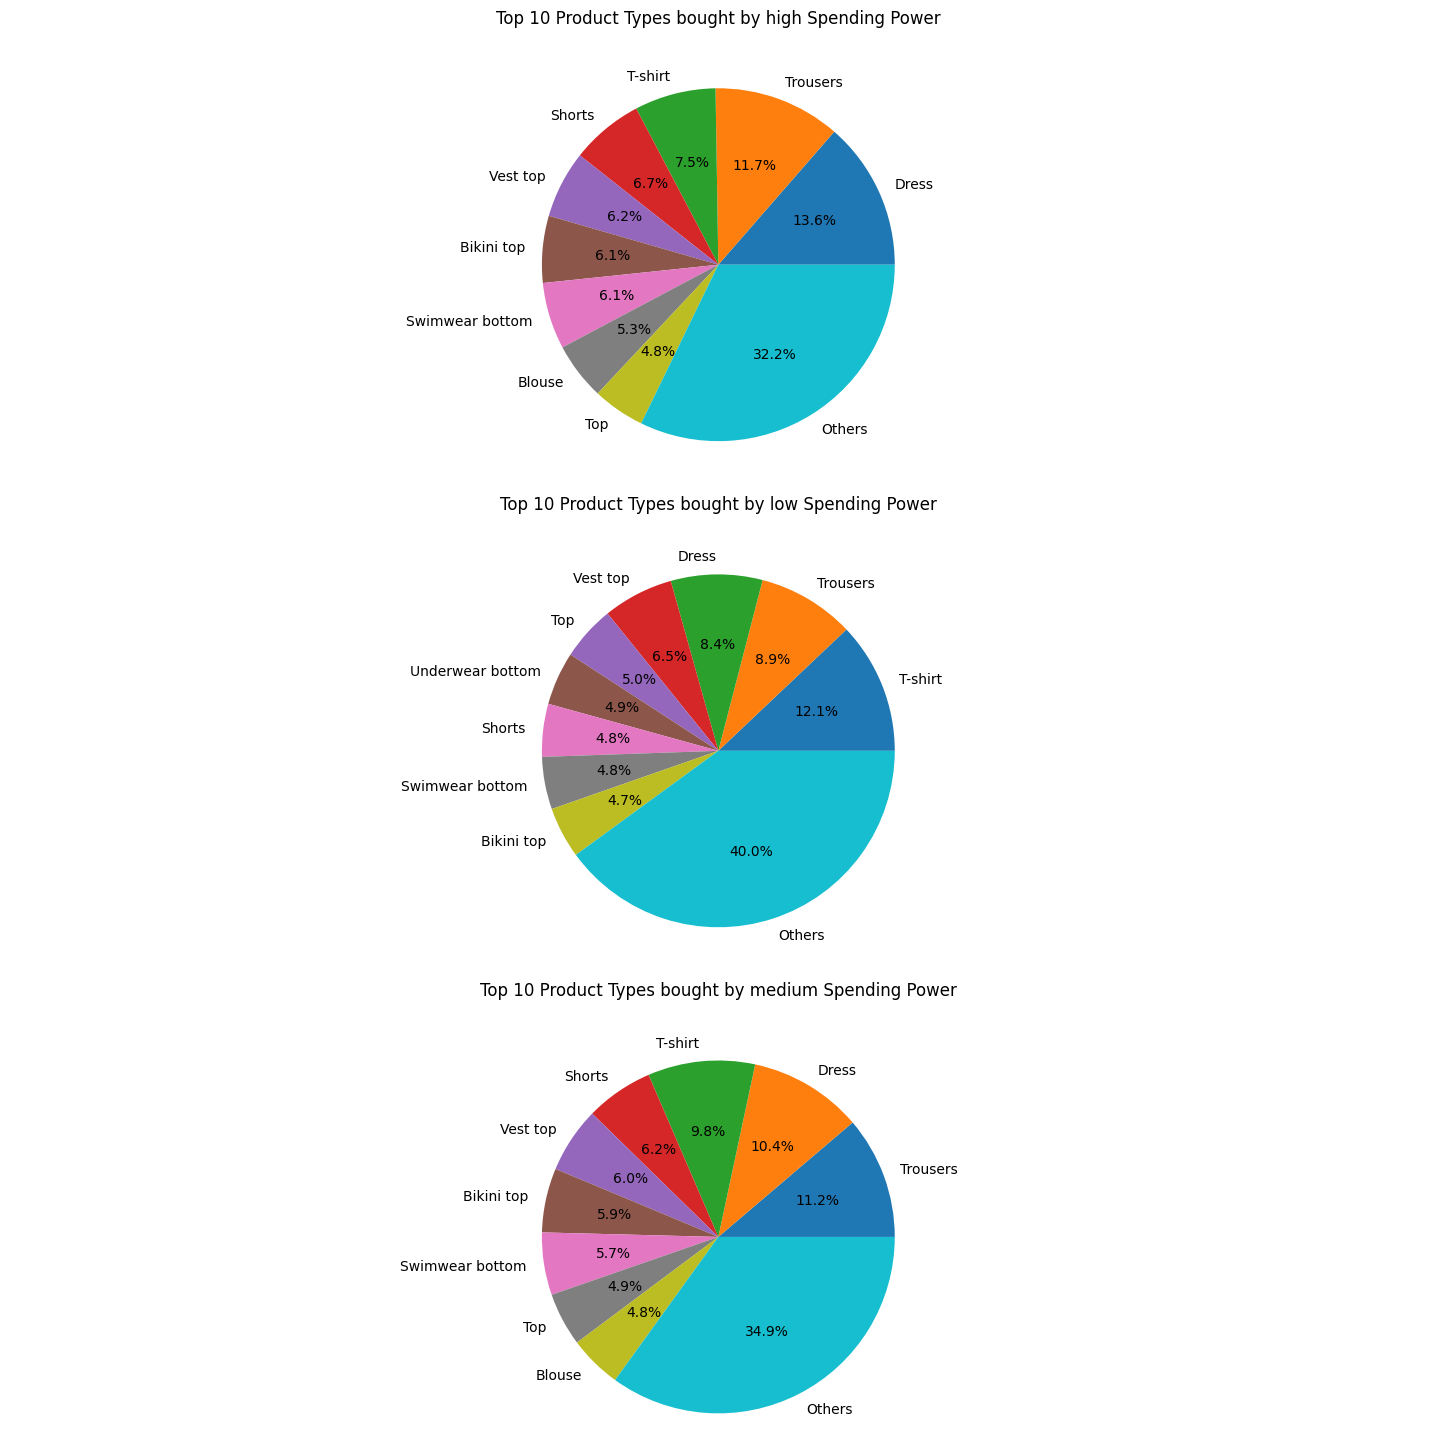

In [72]:
import matplotlib.pyplot as plt

# Group data by spending power and product type and count occurrences
grouped_data = df_train_merged_with_spending_power.groupby(['spending_power', 'product_type_name']).size().reset_index(name='count')
spending_power_categories = grouped_data['spending_power'].unique()

# Plot pie chart for each spending power category
plt.figure(figsize=(15, 5*len(spending_power_categories)))
for i, spending_power in enumerate(spending_power_categories):
    
    # Filter data for the current spending power category
    subset_data = grouped_data[grouped_data['spending_power'] == spending_power]
    
    # Select top 10 product types
    top_10_product_types = subset_data.nlargest(10, 'count')
    
    # Calculate the sum of counts for top 9 product types
    top_9_count = top_10_product_types.iloc[:9]['count'].sum()
    
    # Calculate the count for "Others"
    others_count = subset_data['count'].sum() - top_9_count
    
    # Create a list of labels for the pie chart
    pie_labels = top_10_product_types.iloc[:9]['product_type_name'].tolist()
    pie_labels.append('Others')
    
    # Create a list of counts for the pie chart
    pie_counts = top_10_product_types.iloc[:9]['count'].tolist()
    pie_counts.append(others_count)
    
    # Plot pie chart
    plt.subplot(len(spending_power_categories), 1, i+1)
    plt.pie(pie_counts, labels=pie_labels, autopct='%1.1f%%')
    plt.title(f'Top 10 Product Types bought by {spending_power} Spending Power', y=1.1)
    plt.axis('equal') 

plt.tight_layout(pad=3.0)
plt.show()
